# 03. 조합 테스트
- 일반적으로 웹사이트는 이미지, 텍스트 버튼 등 여러 요소의 조합으로 구성

    $\rightarrow$ 하나의 요소를 업데이트한 디자인 뿐만 아니라 동시에 여러 요소를 변경한 디자인에 관한 테스트가 필요
    
<br>

<br> 

## 03.01. 랜딩 페이지 테스트

- 프로모션의 랜딩페이지의 히어로 이미지 (가장 처음 눈에 들어오는 이미지) 및 사요자가 클릭하는 CTA버튼이 존재
    - 각각 2가지의 이미지과, 2가지의 CTA 버튼 문구의 조합으로 구성된 4개의 조합

<br>


- 무작위로 각 요소의 안들을 사용자에게 노출시킨 결과
    - D안이 다른 안에비해 숫자가 적음

|  | 히어로 이미지 | CTA 문구 | 표시횟수 | 클릭횟수 | 클릭률 |
| - | - | - | - | - | - |
| A안 | 제품 | '지금 구입하기' | 434 | 8 | 1.84% |
| B안 | 제품 | '제품 정보 보기' | 382 | 17 | 4.45% |
| C안 | 샘플 | '지금 구입하기' | 394 | 10 | 2.54% |
| D안 | 샘플 | '제품 정보 보기' | 88 | 4 | 4.55% |

<br>


#### MCMC를 통한 클릭률 추론

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm

In [3]:
n = [434, 382, 394, 88] 
clicks = [8, 17, 10, 4] 

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 23 seconds.
C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_27440\1861247801.py:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=True)


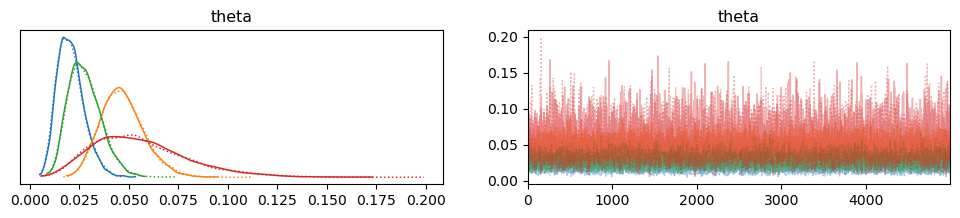

In [4]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=len(n))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace = pm.sample(5000, chains=2)

  pm.traceplot(trace, compact=True) 

- 각 $\theta$의 사후분포와 요약 통계량
    - A안의 평균 클릭률이 가장 낮고, D안의 클릭률이 가장 높음
    - D안은 표시 횟수가 적기 때문에, 다른 분포보다 넓게 퍼져 있음

In [6]:
with model:
    print(pm.summary(trace, hdi_prob=0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.021  0.007     0.008      0.034        0.0      0.0   12958.0   
theta[1]  0.047  0.011     0.026      0.068        0.0      0.0   13354.0   
theta[2]  0.028  0.008     0.013      0.044        0.0      0.0   15669.0   
theta[3]  0.056  0.024     0.014      0.103        0.0      0.0   12512.0   

          ess_tail  r_hat  
theta[0]    7418.0    1.0  
theta[1]    7598.0    1.0  
theta[2]    7037.0    1.0  
theta[3]    6962.0    1.0  


C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_27440\1586716450.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(trace, combined=True, hdi_prob=0.95)


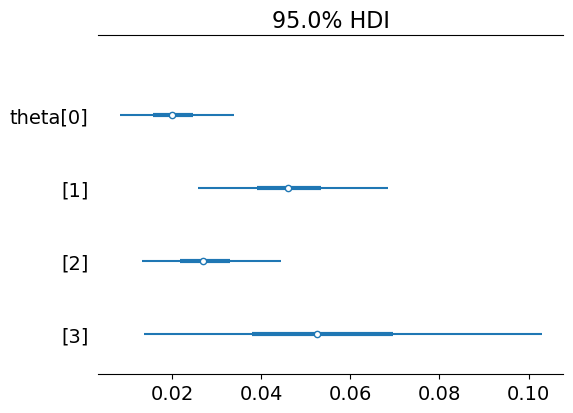

In [7]:
with model:
    pm.forestplot(trace, combined=True, hdi_prob=0.95)

#### 사후분포에 대한 비교검정

<br>

> **가설 1 : $\delta$ = $\theta_B - \theta_A$ > 0**

- **양수인 $\delta$의 비율은 98.21%  $\rightarrow$ 가설 채택**

In [8]:
np.mean(trace['theta'][:, 1] - trace['theta'][:, 0] > 0)

0.9821

<br>

> **가설 2 : $\delta$ = $\theta_D - \theta_A$ > 0**


- **양수인 $\delta$의 비율은 94.92%  $\rightarrow$ 가설 기각**

In [9]:
np.mean(trace['theta'][:, 3] - trace['theta'][:, 0] > 0)

0.9492

<br>

## 03.02. 효과 모델링
- **사후분포를 통하여 각 안의 우열을 비교하는 것이 아니라, 변경을 통하여 클릭률에 미치는 영향 (효과)에 주목**\
    - $\alpha\; (=\beta_0)$ : 베이스라인 (절편)
    - $\beta_1$ : 이미지 효과
    - $\beta_2$ : CTA 버튼 효과

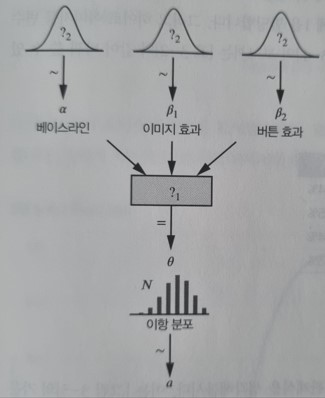

<br>

### 더미변수
- **통계모델링을 위하여 범주형변수들을 수치형으로 변환 $\rightarrow$ 더미 변수화**
    - $x_1$ = 히어로 이미지가 샘플일 때 1, 그렇지 않을 때 0
    - $x_2$ = CTA 문구가 '지금 구입하기'일 때 0, 그렇지 않을 때 1

| $ $ | $x_1$ | $x_2$ | $N$ | $a$ | $\frac{a}{N}$ |
| - | - | - | - | - | - |
| A안 | $0$ | $0$ | 434 | 8 | 1.84% |
| B안 | $0$ | $1$ | 382 | 17 | 4.45% |
| C안 | $1$ | $0$ | 394 | 10 | 2.54% |
| D안 | $1$ | $1$ | 88 | 4 | 4.55% |

<br>

### 로지스틱 함수
- 히어로 이미지에 의한 효과를 $\beta_1$, 히어로 이미지의 종류는 $x_1$ $\rightarrow$ 히어로 이미지의 클릭률에 대한 기여분 = $\beta_1 x_1$

- 클릭률 $\theta$에 대한 회귀식

$$\theta = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$

<br>

- **$\theta$는 0과 1사이의 값이기에 회귀식에 로지스틱 함수의 적용이 필요**

$$logistic(x) = \frac{1}{1+ exp(-x)}$$

$$\theta = logistic(\beta_0 + \beta_1 x_1 + \beta_2 x_2) = \frac{1}{1 + exp(-(\beta_0 + \beta_1 x_1 + \beta_2 x_2))}$$

<br>

#### 로짓 함수
- 로지스틱 함수의 역함수

$$logit(x) = log(\frac{x}{1-x})$$

$$logit(logistic(x)) = log(\frac{\frac{1}{1+e^{-x}}} {1 - \frac{1}{1+e^{-x}}}) = log(\frac{1}{e^{-x}})= log(e^x)=x$$

$$logit(\theta) = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$

<br>

### 정규분포

- 정규분포의 확률밀도함수

$$p(x|\mu, \sigma^2) = N(\mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

<br>

- $\beta_1$은 히어로 이미지를 0에서 1로 변경함에 따른 효과의 크기, $\beta_2$는 버튼의 문구를 0에서 1로 변경함에 따른 효과의 크기를 의미   
        
    $\rightarrow$ **$\theta$에 대한 회귀식 $\beta_0 + \beta_1 x_1 + \beta_2 x_2$와, 회귀식에 대한 로지스틱 함수 적용**
    
    $\rightarrow$ **각 $\beta$에대한 정규사전분포 설정**
    
    
<br>

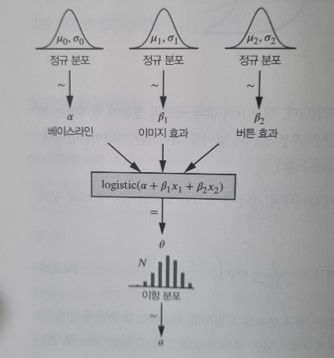

<br>

### 로지스틱 회귀 구현

In [11]:
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

In [12]:
with pm.Model() as model_comb:
  alpha = pm.Normal('alpha', mu=0, sigma=10) # 절편 
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2) # 회귀계수

  comb = alpha + beta[0] * img + beta[1] * btn # 회귀식
  theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb))) # 회귀식에 로지스틱 함수 적용
    
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks) # 이항가능도
  trace_comb = pm.sample(5000, chains=2) 

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 42 seconds.


<br>

- 회귀계수 $\beta_1$, $\beta_2$의 사후분포
    - 히어로 이미지의 효과 $beta_1$는 0부근을 중심으로 분포
    - 버튼 문구의 효과 $\beta_2$의 효과는 0보다 큰 수치 영역에 분포
    
    $\rightarrow$ 버튼 문구를 변경하는 것은 클릭률에 긍정적인 효과

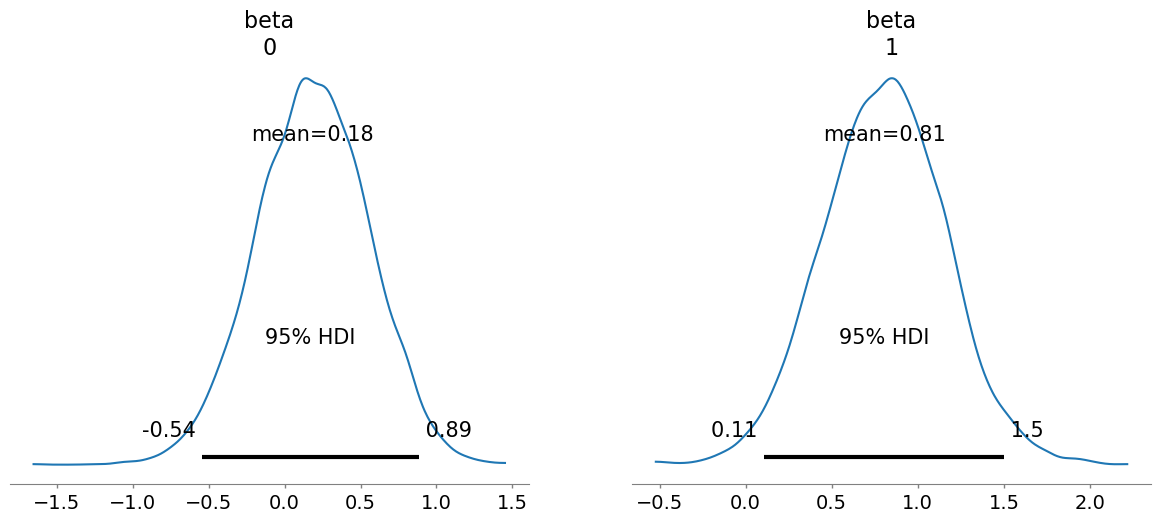

In [13]:
with model_comb:
    pm.plot_posterior(trace_comb, var_names=['beta'], hdi_prob=0.95)

<br>

#### $\beta$에 대한 가설검정

> **가설 : $\beta_2$ > 0**

- **양수인 $\beta$의 비율은 전체 샘플중 98.83% $\rightarrow$ 가설 채택**

In [14]:
np.mean(trace_comb['beta'][:, 1] > 0)

0.9883

<br>


### 모델 비교

- **단일변수 모델 (베타-이항)과 다변수 모델 (로지스틱 모델)에서 $\theta$의 사후분포는 큰 차이가 없으나,**
    
    **전반적으로 다변수 모델의 사후분포가 폭이 더 좁음**
    
    $\rightarrow$ **신뢰도가 소폭 상승**

C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_27440\2079607841.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot([trace, trace_comb], var_names=['theta'],


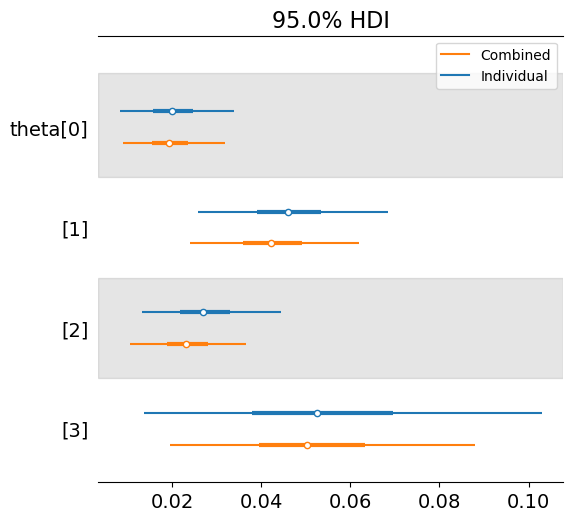

In [17]:
with pm.Model():
    pm.forestplot([trace, trace_comb], var_names=['theta'],
                 hdi_prob=0.95, combined=True, model_names=['Individual', 'Combined'])

<br>

#### 비교검정

<br>

> **가설 1 : $\delta$ = $\theta_B - \theta_A$ > 0**

- **양수인 $\delta$의 비율은 98.83%  $\rightarrow$ 가설 채택**

In [18]:
np.mean(trace_comb['theta'][:, 1] - trace_comb['theta'][:, 0] > .0)

0.9883

<br>

> **가설 2 : $\delta$ = $\theta_D - \theta_A$ > 0**

- **양수인 $\delta$의 비율은 95.62%  $\rightarrow$ 가설 채택** 

    **단일변수 모델의 경우와 다른 결과**

In [19]:
np.mean(trace_comb['theta'][:, 3] - trace_comb['theta'][:, 0] > .0)

0.9562

<br>

## 03.04. 모델수정

- $D$안에 대한 관측값 추가

| $ $ | $x_1$ | $x_2$ | $N$ | $a$ | $\frac{a}{N}$ |
| - | - | - | - | - | - |
| A안 | $0$ | $0$ | 434 | 8 | 1.84% |
| B안 | $0$ | $1$ | 382 | 17 | 4.45% |
| C안 | $1$ | $0$ | 394 | 10 | 2.54% |
| D안 | $1$ | $1$ | 412 | 8 | 1.94% |

In [23]:
n = [434, 382, 394, 412]
clicks = [8, 17, 10, 8]
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 42 seconds.
C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_27440\746641948.py:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_comb2, compact=True)  # 그림 3-12


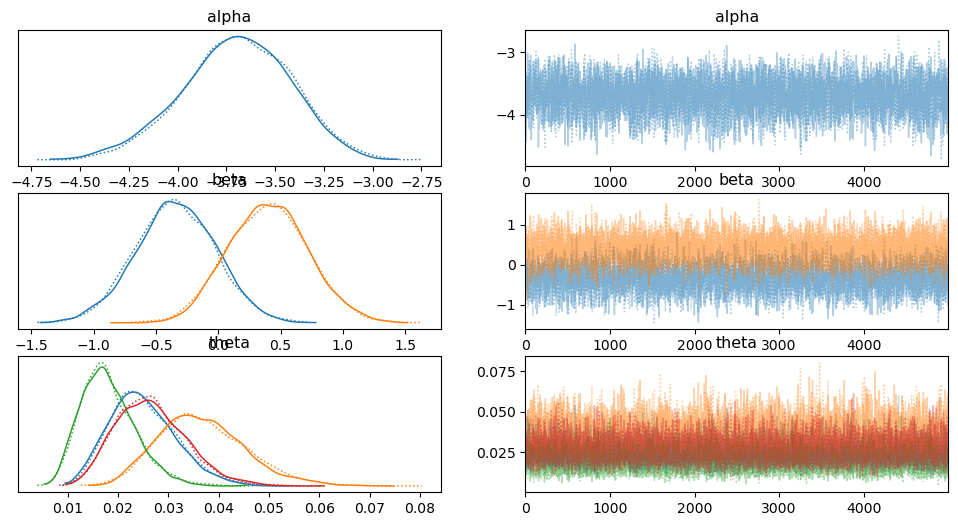

In [24]:
with pm.Model() as model_comb2:
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] * btn
  theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb2 = pm.sample(5000, chains=2)

  pm.traceplot(trace_comb2, compact=True) 

<br>

- **이전 모델에서는 $\beta_2$가 클릭률에 긍정적인 효과를 미친다고 판단되었으나**

    **$\beta_2 > 0$ 가설에 대한 신규 데이터에서는 그렇지 않음**

In [25]:
np.mean(trace_comb2['beta'][:, 1] > .0)

0.8939

<br>

### 주효과 (Main Effect)
- **어떠한 요소가 직접적으로 미치는 결과**
    
    예) 히어로 이미지의 효과, 버튼 문구의 효과

<br>

### 교호작용 (Interaction Effect)
- 여러 요소를 조합함에 따라 나타나는 효과
- **이전의 데이터에서는 D안 [1, 1]의 표본이 작았음에도 불구하고,**
    
    **A안 [0, 0], B안 [0, 1]간의 차이에 따라, $\beta_2$의 주효과가 추론된 것**

<br>

### 교호작용이 추가된 모델

$$\theta = logistic(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2)$$


C:\Users\FORYOUCOM\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 65 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_27440\3476657534.py:10: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_int, compact=True)


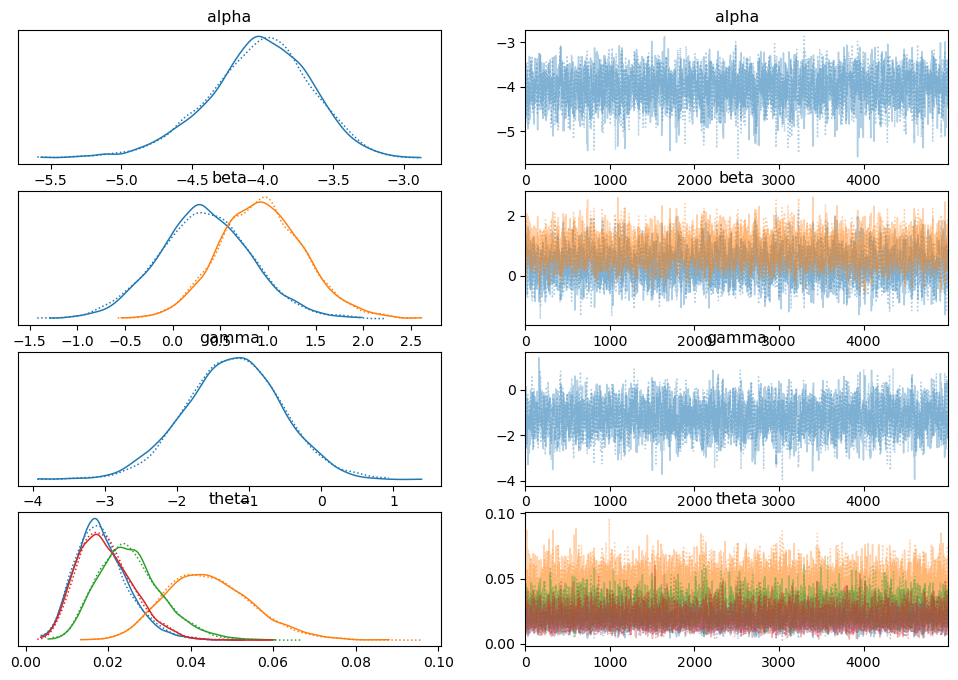

In [26]:
with pm.Model() as model_int:
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  gamma = pm.Normal('gamma', mu=0, sigma=10)
  comb = alpha + beta[0] * img + beta[1] * btn + gamma * img * btn
  theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks) 
  trace_int = pm.sample(5000, chains=2)

  pm.traceplot(trace_int, compact=True)  

<br>

- **교호작용 $\beta_3$의 사후분포가 음수 $\rightarrow$ 새로운 데이터에서는 음의 교호작용이 존재**

In [28]:
np.mean(trace_int['gamma'] > 0)

0.0329

- **새로운 데이터에서는 히어로 이미지의 효과 $\beta_1$이 0보다 크다고 보기 어려우며,**
    
    **버튼 문구의 효과 $\beta_2$가 0보다 크다고 볼 수 있음**

In [31]:
np.mean(trace_int['beta'][:, 0] > 0), np.mean(trace_int['beta'][:, 1] > 0)

(0.7569, 0.9835)

<br>

## 03.05. 모델 선택

<br>

### 반응표면분석

<br>

#### 주효과 $x_1$, $x_2$의 변동에 따른 $logit(\theta)$의 변동
- $x_1$ 값이 클수록 클릭률 $logit(\theta)$가 낮아짐 
- $x_2$ 값이 클수록 클릭률 $logit(\theta)$가 증가

In [32]:
from mpl_toolkits.mplot3d import Axes3D

In [33]:
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)

C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_27440\3828947164.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


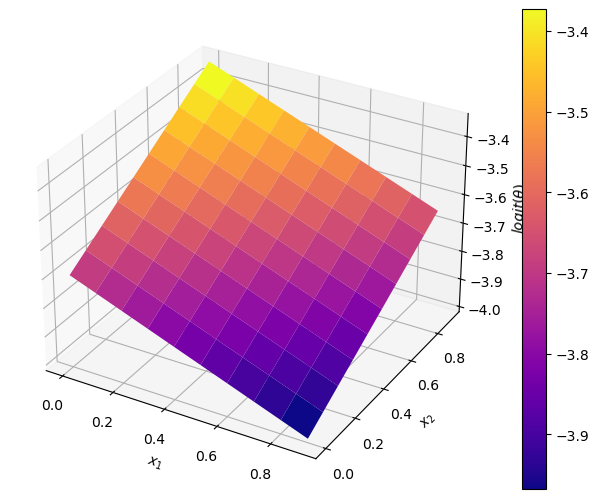

In [34]:
fig = plt.figure()
ax = Axes3D(fig)
logit_theta = (trace_comb2['alpha'].mean() + trace_comb2['beta'][:, 0].mean() * X1 +trace_comb2['beta'][:, 1].mean() * X2)
surf = ax.plot_surface(X1, X2, logit_theta, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()  

<br>

#### 교호작용을 포함한 $logit(\theta)$의 변동
- **$x_1$, $x_2$ 모두 1이면, 클릭률이 낮아지는 음의 교호작용을 무시할 수 없음** 

In [35]:
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)

C:\Users\FORYOUCOM\AppData\Local\Temp\ipykernel_27440\72100593.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


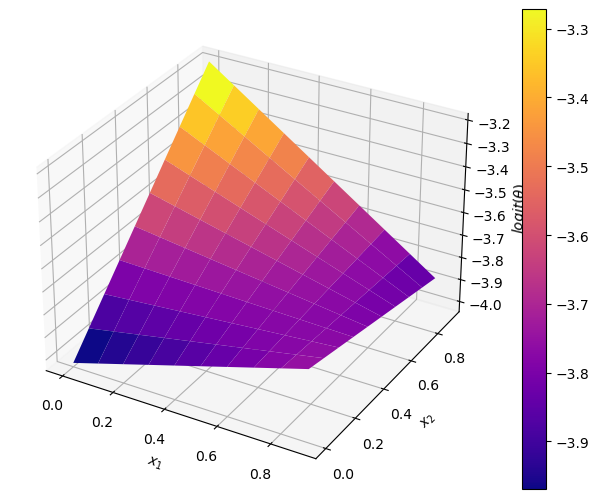

In [36]:
fig = plt.figure()
ax = Axes3D(fig)
Y = (trace_int['alpha'].mean() + trace_int['beta'][:, 0].mean() * X1 +
     trace_int['beta'][:, 1].mean() * X2 + trace_int['gamma'].mean() * X1 * X2)
surf = ax.plot_surface(X1, X2, Y, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show() 

<br>

#### $\rightarrow$ 교호작용의 추가를 통하여, 주효과 $\beta_1$, $\beta_2$ 사후분포의 편자가 적어지고 분포의 폭이 좁아짐


<br>

### 모델링 유의사항

<br>

#### 다중공선성

- **모델에 포함된 2개의 변수 사이에 큰 상관관계가 존재하는 경우, 둘 중 하나의 변수가 없어져야 함**
   
   $\rightarrow$ **제거하지 않는다면, 두 변수에 의한 기여도를 할당하는데 문제가 발생**
   
   $\rightarrow$ **극단적으로 큰 값과 작은 값으로 나누어져 데이터에 포함되는 노이즈에 큰 영향을 미쳐 결과가 불안정**
   
   $\rightarrow$ **다중공선성**
   

<br>

- 모델링을 할 때는, 단순한 모델에서 시작하여 변수를 추가하는 방식이 바람직하며,
    
    너무 간단하거나 복잡해서도 안됨

<br>

#### WAIC (idely Applicable Information criterion, Watanabe-Akaike Information Criterion)

#### `pm.waic()`
- 값이 작을수록 좋은 모델

In [37]:
waic_comb2 = pm.waic(trace_comb2, model_comb2)
waic_int = pm.waic(trace_int, model_int)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\FORYOUCOM\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return 

In [38]:
print(waic_comb2.p_waic) 
print(waic_int.p_waic) 

3.7090706030084526
2.1414245259883478
